# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### Google Drive

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import os

GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643-project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Project Proposal.pdf', 'environment.yaml', 'project notes.docx', 'the-verdict.txt', 'README.md', 'sentiment_fine_tune', 'instr_fine_tune', 'model', '.git']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/cs7643-project']

In [6]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/cs7643-project`


### General Imports

In [7]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.8 MB/s eta 0:00:00


In [8]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
import urllib
from pathlib import Path
import time
from tqdm import tqdm
import numpy as np
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: " + device)

Device: cuda


# 1. Test model implementations

## 1.0 Utils

### Training Utils

In [9]:
"""Contains functions to train the model for sentiment analysis fine tuning."""

import math
import torch
from dataclasses import dataclass

# Sentiment task based CE loss calculations
def calc_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device).long()
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loader_loss(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

# Sentiment task based accuracy calculations
def calc_loader_accuracy(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

@dataclass
class TrainingConfig:
    model: torch.nn.Module
    train_loader: torch.utils.data.DataLoader
    val_loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    device: torch.device
    num_epochs: int
    eval_freq: int
    eval_iter: int
    tokenizer: object
    warmup_steps: int = None
    initial_lr: float = 3e-05
    min_lr: float = 1e-6
    run_name: str = "test"

@dataclass
class TrainingResults:
    train_losses: list
    val_losses: list
    track_tokens_seen: list
    train_perplexity: list
    val_perplexity: list
    track_lrs: list = None


def train_model_simple(config: TrainingConfig):
    train_losses, val_losses, track_tokens_seen = [], [], []
    train_perplexity, val_perplexity = [], []
    tokens_seen, global_step = 0, -1

    # 1) Iterate over training epochs
    for epoch in range(config.num_epochs):
        config.model.train()

        # 2) Iterate over batches
        for input_batch, target_batch in config.train_loader:
            # 3) Reset loss gradients from previous batch iteration
            config.optimizer.zero_grad()

            # 4) Calculate loss on current batch
            loss = calc_batch_loss(input_batch, target_batch, config.model, config.device)

            # 5) Backward pass to calculate loss gradients
            loss.backward()

            # 6) Update model weights using loss gradients
            config.optimizer.step()

            # 7a) Logging
            tokens_seen += input_batch.numel()
            global_step += 1

            # 7b) Optional evaluation step
            if global_step % config.eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    config.model, config.train_loader, config.val_loader, config.device, config.eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_perplexity.append(torch.exp(torch.tensor(train_loss)).item())
                val_perplexity.append(torch.exp(torch.tensor(val_loss)).item())
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f} "
                      f"Train perplexity {train_perplexity[-1]:.3f}, Val perplexity {val_perplexity[-1]:.3f}")

    return TrainingResults(
        train_losses=train_losses,
        val_losses=val_losses,
        track_tokens_seen=track_tokens_seen,
        train_perplexity=train_perplexity,
        val_perplexity=val_perplexity
    )

def train_model(config: TrainingConfig):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    train_perplexity, val_perplexity = [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the initial l.r from the optimizer, assuming we use it as the peak l.r
    peak_lr = config.optimizer.param_groups[0]["lr"]

    # Calculate the total number of steps in the training process
    total_training_steps = len(config.train_loader) * config.num_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - config.initial_lr) / config.warmup_steps

    # 1) Iterate over training epochs
    for epoch in range(config.num_epochs):
        config.model.train()

        # 2) Iterate over batches
        for input_batch, target_batch in config.train_loader:
            # 3) Reset loss gradients from previous batch iteration
            config.optimizer.zero_grad()
            global_step += 1

            # 4) Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < config.warmup_steps:
                # 4a) Linear warmup
                lr = config.initial_lr + global_step * lr_increment
            else:
                # 4b) Cosine annealing after warmup
                progress = ((global_step - config.warmup_steps) /
                            (total_training_steps - config.warmup_steps))
                lr = config.min_lr + (peak_lr - config.min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            # 4c) Apply the calculated learning rate to the optimizer
            for param_group in config.optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # 5) Calculate and backpropagate the loss to fill grad
            loss = calc_batch_loss(input_batch, target_batch, config.model, config.device)
            loss.backward()

            # 6) Apply gradient clipping after the warmup phase to avoid exploding gradients
            if global_step >= config.warmup_steps:
                torch.nn.utils.clip_grad_norm_(config.model.parameters(), max_norm=1.0)

            # 7) Update model weights using clipped gradients
            config.optimizer.step()
            tokens_seen += input_batch.numel()

            # 8) Periodically evaluate the model on the training and validation sets
            if global_step % config.eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    config.model, config.train_loader, config.val_loader,
                    config.device, config.eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_perplexity.append(torch.exp(torch.tensor(train_loss)).item())
                val_perplexity.append(torch.exp(torch.tensor(val_loss)).item())
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}, "
                      f"Train perplexity {train_perplexity[-1]:.3f}, "
                      f"Val perplexity {val_perplexity[-1]:.3f}, "
                      f"LR {lr:.3e}"
                      )


    return TrainingResults(
        train_losses=train_losses,
        val_losses=val_losses,
        track_tokens_seen=track_tokens_seen,
        train_perplexity=train_perplexity,
        val_perplexity=val_perplexity,
        track_lrs=track_lrs
    )


### Plotting Utils

In [10]:
from typing import List, Optional
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def _plot_metric_vs_epochs(
    training_config: TrainingConfig,
    tokens_seen: List[float], # Or torch.Tensor if you keep them as tensors
    train_data: List[float], # Or torch.Tensor
    val_data: List[float], # Or torch.Tensor
    train_label: str,
    val_label: str,
    y_label: str,
    filepath: Optional[str] = None
):

    fig, ax1 = plt.subplots(figsize=(7, 5))

    num_data_points = len(train_data)
    epochs_seen = torch.linspace(0, training_config.num_epochs, num_data_points)

    ax1.plot(epochs_seen, train_data, label=train_label)
    ax1.plot(epochs_seen[:len(val_data)], val_data[:len(epochs_seen)], linestyle="-.", label=val_label)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(y_label)
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_data, alpha=0)
    ax2.set_xlabel("Tokens seen")
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'))

    min_val_loss = min(val_data)
    min_val_idx = val_data.index(min_val_loss)
    min_epoch = epochs_seen[min_val_idx]
    ax1.scatter(min_epoch, min_val_loss, color='red', s=50, zorder=5, label=f'Best {val_label}')
    annotation_text = f'Val Min: {min_val_loss:.3f}'
    ax1.annotate(annotation_text,
                    xy=(min_epoch, min_val_loss),
                    xytext=(min_epoch-0.1, min_val_loss + (max(val_data) - min_val_loss)*0.3),
                    textcoords='data',
                    ha='center',
                    va='bottom',
                    arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=.2"))


    fig.tight_layout()
    plt.grid()
    plt.show()

def plot_losses(training_config: TrainingConfig, training_results: TrainingResults):
    print("Plotting losses...")
    _plot_metric_vs_epochs(
        training_config=training_config,
        # Using track_tokens_seen as in the original function
        tokens_seen=training_results.track_tokens_seen,
        train_data=training_results.train_losses,
        val_data=training_results.val_losses,
        train_label="Training loss",
        val_label="Validation loss",
        y_label="Loss",
    )

### GPT2 Utils

In [11]:
"""Contains the Model Architecture for the GPT model. -- Base code"""

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)                        # Shape: (b, num_tokens, d_out) = (b, m, d_in) * (d_in, d_out)
        queries = self.W_query(x)                   # Shape: (b, num_tokens, d_out) = (b, m, d_in) * (d_in, d_out)
        values = self.W_value(x)                    # Shape: (b, num_tokens, d_out) = (b, m, d_in) * (d_in, d_out)

        # We implicitly split the matrices:
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # (b, num_heads, num_tokens, num_tokens) = (b, num_heads, num_tokens, head_dim) * (b, num_heads, head_dim, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Shape of attn_weights = (b, num_heads, num_tokens, num_tokens)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape of attn_weights @ values: (b, num_heads, num_tokens, num_tokens) * (b, num_heads, num_tokens, head_dim) = (b, num_heads, num_tokens, head_dim)
        # Shape of context_vec: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        # Shape of context_vec = (b, num_tokens, d_out)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # Shape of context_vec: (b, num_tokens, d_out) = (b, num_tokens, d_out) * (d_out, d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        """ x is of shape (batch_size, num_tokens, emb_dim) """
        mean = x.mean(dim=-1, keepdim=True)                     # Shape: (b, num_tokens, 1)
        var = x.var(dim=-1, keepdim=True, unbiased=False)       # Shape: (b, num_tokens, 1)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)        # Shape: (b, num_tokens, emb_dim)
        return self.scale * norm_x + self.shift                 # Shape: (b, num_tokens, emb_dim)


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        """ x is of shape (batch_size, num_tokens, emb_dim) """
        return self.layers(x)       # Output Shape: (b, num_tokens, emb_dim)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.multi_head_att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.layer_norm1 = LayerNorm(cfg["emb_dim"])
        self.layer_norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x                                # (b, num_tokens, emb_dim)
        x = self.layer_norm1(x)                     # (b, num_tokens, emb_dim)
        x = self.multi_head_att(x)                  # (b, num_tokens, emb_dim)
        x = self.drop_shortcut(x)                   # (b, num_tokens, emb_dim)
        x = x + shortcut                            # (b, num_tokens, emb_dim)

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.layer_norm2(x)                     # (b, num_tokens, emb_dim)
        x = self.ff(x)                              # (b, num_tokens, emb_dim)
        x = self.drop_shortcut(x)                   # (b, num_tokens, emb_dim)
        x = x + shortcut                            # (b, num_tokens, emb_dim)

        return x                                    # (b, num_tokens, emb_dim)


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_layer_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, input_tok_ids, return_hidden_states=False):
        """ input_tok_ids is of shape (batch_size, num_tokens) """
        batch_size, seq_len = input_tok_ids.shape
        tok_embeds = self.tok_emb(input_tok_ids)                # Shape: (batch_size, num_tokens, emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=input_tok_ids.device))
        x = tok_embeds + pos_embeds                             # Shape: (batch_size, num_tokens, emb_dim)
        x = self.drop_emb(x)                                    # Shape: (batch_size, num_tokens, emb_dim)
        x = self.trf_blocks(x)                                  # Shape: (batch_size, num_tokens, emb_dim)
        x = self.final_layer_norm(x)                            # Shape: (batch_size, num_tokens, emb_dim)

        if return_hidden_states:
            return x  # Return hidden states instead of logits

        logits = self.out_head(x)                               # Shape: (batch_size, num_tokens, vocab_size)
        return logits


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def print_model_stats(model: GPTModel, model_name: str):
    print("Model Name:", model_name)

    # Print parameter count
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\tTotal Parameters: {total_params:,}")

    # Print memory requirement
    total_size_bytes = total_params * 4
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"\tTotal Memory Requirement: {total_size_mb:.2f} MB")


### LoRA Utils

In [12]:
"""Contains modules to create LoRA layers for the GPT model. -- Base code"""

import torch
import torch.nn as nn
import math
from model.gpt import GPTModel, TransformerBlock


class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)


def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)


def _apply_lora_to_module(module, rank, alpha):
    """Recursively replaces nn.Linear layers with LinearWithLoRA within a module."""
    for name, child_module in module.named_children():
        if isinstance(child_module, nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            # Make sure the original linear layer's weights are preserved
            original_linear = child_module
            lora_linear = LinearWithLoRA(original_linear, rank, alpha)
            setattr(module, name, lora_linear)
            # print(f"Replaced {name} in {module.__class__.__name__} with LoRA.") # Optional: for debugging
        else:
            # Recursively apply the same function to child modules
            _apply_lora_to_module(child_module, rank, alpha)


def replace_linear_with_lora_last_n(model: GPTModel, n: int, rank: int, alpha: float):
    """
    Replaces nn.Linear layers with LinearWithLoRA layers only in the last 'n'
    TransformerBlocks of the GPTModel.

    Args:
        model (GPTModel): The GPT model instance.
        n (int): The number of final transformer blocks to modify.
        rank (int): The rank of the LoRA decomposition.
        alpha (float): The alpha scaling factor for LoRA.
    """
    if not isinstance(model, GPTModel):
        raise TypeError("Model must be an instance of GPTModel")
    if not hasattr(model, 'trf_blocks') or not isinstance(model.trf_blocks, nn.Sequential):
         raise ValueError("Model does not have the expected 'trf_blocks' Sequential module.")

    num_total_blocks = len(model.trf_blocks)

    if n <= 0:
        print("Warning: n <= 0. No LoRA layers will be added.")
        return
    if n > num_total_blocks:
         print(f"Warning: n ({n}) is greater than the total number of transformer blocks ({num_total_blocks}). Applying LoRA to all transformer blocks.")
         n = num_total_blocks # Or raise an error if preferred

    # Calculate the starting index of the blocks to modify
    start_index = num_total_blocks - n

    print(f"Applying LoRA with rank={rank}, alpha={alpha} to the last {n} transformer blocks (indices {start_index} to {num_total_blocks - 1}).")

    # Iterate through only the last n blocks
    for i in range(start_index, num_total_blocks):
        block_to_modify = model.trf_blocks[i]
        if isinstance(block_to_modify, TransformerBlock):
             # Apply the recursive replacement function *only* to this block
            _apply_lora_to_module(block_to_modify, rank, alpha)
        else:
            print(f"Warning: Expected TransformerBlock at index {i}, but found {type(block_to_modify)}. Skipping.")

    # Apply lora to out head
    model.out_head = LinearWithLoRA(model.out_head, rank, alpha)


def convert_to_lora_model(model: GPTModel, rank: int, alpha: int, last_n_trf_blocks=None) -> GPTModel:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters before: {total_params:,}")

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the classification head - SENTIMENT BASED CODE ADAPTION.
    if hasattr(model, 'out_head'):
        for param in model.out_head.parameters():
            param.requires_grad = True

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters after: {total_params:,}")

    if last_n_trf_blocks is not None:
        replace_linear_with_lora_last_n(model, n=last_n_trf_blocks, rank=rank, alpha=alpha)
    else:
        replace_linear_with_lora(model, rank=rank, alpha=alpha)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters: {total_params:,}")
    model.to(device)
    return model

In [13]:
from transformers import GPT2Model
from model.load_model import load_weights

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

def get_pretrained_gpt_model(model_name, verbose=True):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    gpt_model = GPTModel(base_config_copy)

    hf_pretrained_gpt = GPT2Model.from_pretrained(model_names[model_name], cache_dir="checkpoints")
    load_weights(gpt_model, hf_pretrained_gpt, base_config_copy)

    if verbose:
        print_model_stats(gpt_model, model_name)

    return gpt_model, base_config_copy  # NEED CONFIG - SENTIMENT BASED CODE ADAPTION

## 1.1 Test raw GPT model

In [ ]:
import torch
import tiktoken

# GPT Configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
test_gpt_model = GPTModel(GPT_CONFIG_124M)
test_gpt_model.eval()

classification_head = torch.nn.Sequential(
    torch.nn.Linear(GPT_CONFIG_124M["emb_dim"], 1),
    torch.nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_gpt_model.to(device)
classification_head.to(device)

tokenizer = tiktoken.get_encoding("gpt2")

input_text = "I love this product! It's amazing and works perfectly."

encoded_tensor = text_to_token_ids(input_text, tokenizer).to(device)

encoded_tensor = encoded_tensor[:, :GPT_CONFIG_124M["context_length"]]

with torch.no_grad():
    hidden_states = test_gpt_model(encoded_tensor, return_hidden_states=True)

last_hidden_state = hidden_states[:, -1, :]

logits = classification_head(last_hidden_state)

prediction = (logits > 0.5).long()

print(f"Input Text: {input_text}")
print(f"Sentiment Prediction: {'Positive' if prediction.item() == 1 else 'Negative'}")

Input Text: I love this product! It's amazing and works perfectly.
Sentiment Prediction: Negative


In [ ]:
total_params = sum(p.numel() for p in test_gpt_model.parameters())
print(f"Total Parameters: {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in test_gpt_model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Total Parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
print_model_stats(test_gpt_model, "GPT-124M")

Model Name: GPT-124M
	Total Parameters: 163,009,536
	Total Memory Requirement: 621.83 MB


## 1.2 Test pretrained GPT model

In [ ]:
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "gpt2-large (774M)"
test_pretrained_gpt, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
test_pretrained_gpt.eval()  # Disable dropout for evaluation

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
# classification head for sentiment analysis
classification_head = torch.nn.Sequential(
    torch.nn.Linear(gpt_config["emb_dim"], 1),
    torch.nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_pretrained_gpt.to(device)
classification_head.to(device)

tokenizer = tiktoken.get_encoding("gpt2")

input_text = "I love this product! It's amazing and works perfectly."

encoded = tokenizer.encode(input_text, allowed_special={"<|endoftext|>"})
encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)

encoded_tensor = encoded_tensor[:, :gpt_config["context_length"]]

with torch.no_grad():
    hidden_states = test_pretrained_gpt(encoded_tensor, return_hidden_states=True)

last_hidden_state = hidden_states[:, -1, :]

logits = classification_head(last_hidden_state)

prediction = (logits > 0.5).long()

print(f"Input Text: {input_text}")
print(f"Sentiment Prediction: {'Positive' if prediction.item() == 1 else 'Negative'}")

Input Text: I love this product! It's amazing and works perfectly.
Sentiment Prediction: Positive


In [ ]:
test_lora_gpt, gpt_config = get_pretrained_gpt_model("gpt2-small (124M)", verbose=False)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in test_lora_gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

In [ ]:
# replace_linear_with_lora(test_lora_gpt, rank=16, alpha=16)
replace_linear_with_lora_last_n(test_lora_gpt, n=2, rank=16, alpha=16)

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

# 2. Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 50000 samples.
Training samples: 40000, Testing samples: 10000
Example training sample: There is an excellent reason Edison went straight to video: it would have landed in theaters with a crumbling thud. The movie lasted entirely too long and was perilously boring. Just a notch above lowbrow (thanks to Freeman and Spacey, who obviously had a spare two weeks before their next films), the bad guys are as laughable and action as near non-existent as Justin Timberlake's acting. I hate to knock the guy, but the sooner he realizes that pop is his forte, the better.<br /><br />The movie isn't all bad...just mostly. I like the fact that LL Cool J was given what appears to be a shot at being leading man. He deserves it. And, unlike his fellow musician and co-star, he can act. Kevin Spacey is almost always enjoyable as well (you can see him gulp several times as he chews the scenery), and Freeman has the ability to elevate this flick to three stars (out of ten...he's not THAT good).<br />

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

# 3. Training Model - Fine Tune Normal - 50k/256/32/small

In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-small (124M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
     

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.5652036666870117
Validation loss: 1.5472045183181762


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.411, Val loss 1.484 Train perplexity 4.099, Val perplexity 4.410
Ep 1 (Step 000005): Train loss 0.932, Val loss 0.961 Train perplexity 2.540, Val perplexity 2.616
Ep 1 (Step 000010): Train loss 0.824, Val loss 0.824 Train perplexity 2.280, Val perplexity 2.281
Ep 1 (Step 000015): Train loss 0.804, Val loss 0.789 Train perplexity 2.234, Val perplexity 2.201
Ep 1 (Step 000020): Train loss 0.758, Val loss 0.803 Train perplexity 2.135, Val perplexity 2.233
Ep 1 (Step 000025): Train loss 0.685, Val loss 0.737 Train perplexity 1.984, Val perplexity 2.090
Ep 1 (Step 000030): Train loss 0.689, Val loss 0.746 Train perplexity 1.992, Val perplexity 2.109
Ep 1 (Step 000035): Train loss 0.717, Val loss 0.779 Train perplexity 2.049, Val perplexity 2.179
Ep 1 (Step 000040): Train loss 0.621, Val loss 0.702 Train perplexity 1.860, Val perplexity 2.017
Ep 1 (Step 000045): Train loss 0.662, Val loss 0.718 Train perplexity 1.939, Val perplexity 2.051
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9176


Plotting losses...


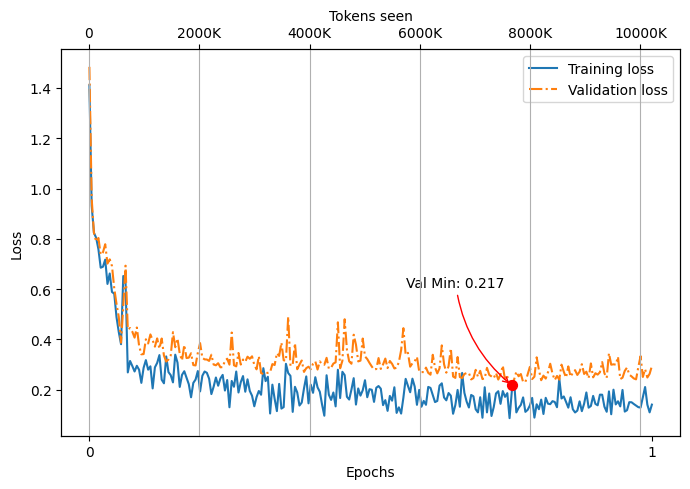

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/256/32/small

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-small (124M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
     

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.4264358162879944
Validation loss: 1.3612260103225708


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.314, Val loss 1.266 Train perplexity 3.722, Val perplexity 3.546
Ep 1 (Step 000005): Train loss 0.840, Val loss 0.851 Train perplexity 2.315, Val perplexity 2.342
Ep 1 (Step 000010): Train loss 0.776, Val loss 0.736 Train perplexity 2.173, Val perplexity 2.088
Ep 1 (Step 000015): Train loss 0.731, Val loss 0.718 Train perplexity 2.077, Val perplexity 2.051
Ep 1 (Step 000020): Train loss 0.708, Val loss 0.722 Train perplexity 2.029, Val perplexity 2.058
Ep 1 (Step 000025): Train loss 0.663, Val loss 0.671 Train perplexity 1.941, Val perplexity 1.956
Ep 1 (Step 000030): Train loss 0.668, Val loss 0.668 Train perplexity 1.950, Val perplexity 1.950
Ep 1 (Step 000035): Train loss 0.659, Val loss 0.633 Train perplexity 1.933, Val perplexity 1.883
Ep 1 (Step 000040): Train loss 0.618, Val loss 0.608 Train perplexity 1.856, Val perplexity 1.836
Ep 1 (Step 000045): Train loss 0.547, Val loss 0.594 Train perplexity 1.728, Val perplexity 1.812
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.905


Plotting losses...


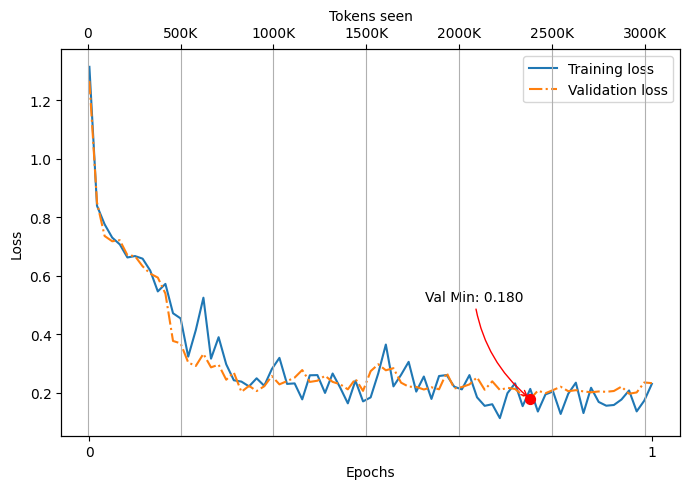

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/1024/4/small

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-small (124M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
     

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, gpt_config["context_length"])
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, gpt_config["context_length"])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: collate_fn(x, gpt_config["context_length"]))
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: collate_fn(x, gpt_config["context_length"]))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.7273718118667603
Validation loss: 0.7199908494949341


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.080, Val loss 1.181 Train perplexity 2.945, Val perplexity 3.259
Ep 1 (Step 000005): Train loss 0.696, Val loss 0.706 Train perplexity 2.006, Val perplexity 2.026
Ep 1 (Step 000010): Train loss 0.909, Val loss 0.814 Train perplexity 2.481, Val perplexity 2.256
Ep 1 (Step 000015): Train loss 0.732, Val loss 0.701 Train perplexity 2.079, Val perplexity 2.016
Ep 1 (Step 000020): Train loss 0.687, Val loss 0.702 Train perplexity 1.987, Val perplexity 2.017
Ep 1 (Step 000025): Train loss 0.820, Val loss 0.786 Train perplexity 2.271, Val perplexity 2.195
Ep 1 (Step 000030): Train loss 0.731, Val loss 0.727 Train perplexity 2.078, Val perplexity 2.069
Ep 1 (Step 000035): Train loss 0.759, Val loss 0.718 Train perplexity 2.137, Val perplexity 2.050
Ep 1 (Step 000040): Train loss 0.740, Val loss 0.787 Train perplexity 2.095, Val perplexity 2.197
Ep 1 (Step 000045): Train loss 0.758, Val loss 0.708 Train perplexity 2.135, Val perplexity 2.030
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.926


Plotting losses...


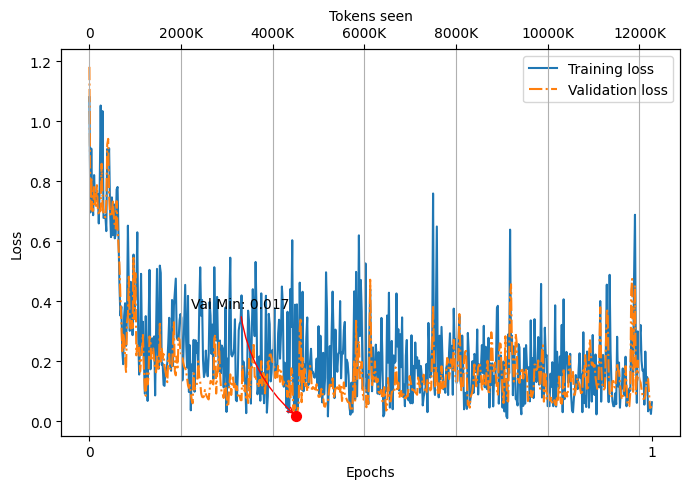

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/256/8/medium

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-medium (355M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.5062713623046875
Validation loss: 2.2917818784713746


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.538, Val loss 1.215 Train perplexity 4.657, Val perplexity 3.371
Ep 1 (Step 000005): Train loss 1.052, Val loss 1.187 Train perplexity 2.863, Val perplexity 3.278
Ep 1 (Step 000010): Train loss 0.916, Val loss 1.083 Train perplexity 2.499, Val perplexity 2.955
Ep 1 (Step 000015): Train loss 0.733, Val loss 0.943 Train perplexity 2.082, Val perplexity 2.568
Ep 1 (Step 000020): Train loss 0.690, Val loss 0.925 Train perplexity 1.993, Val perplexity 2.522
Ep 1 (Step 000025): Train loss 0.766, Val loss 0.874 Train perplexity 2.151, Val perplexity 2.397
Ep 1 (Step 000030): Train loss 0.784, Val loss 0.860 Train perplexity 2.190, Val perplexity 2.363
Ep 1 (Step 000035): Train loss 0.648, Val loss 0.823 Train perplexity 1.913, Val perplexity 2.276
Ep 1 (Step 000040): Train loss 0.731, Val loss 0.767 Train perplexity 2.077, Val perplexity 2.154
Ep 1 (Step 000045): Train loss 0.659, Val loss 0.790 Train perplexity 1.932, Val perplexity 2.204
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9323333333333333


Plotting losses...


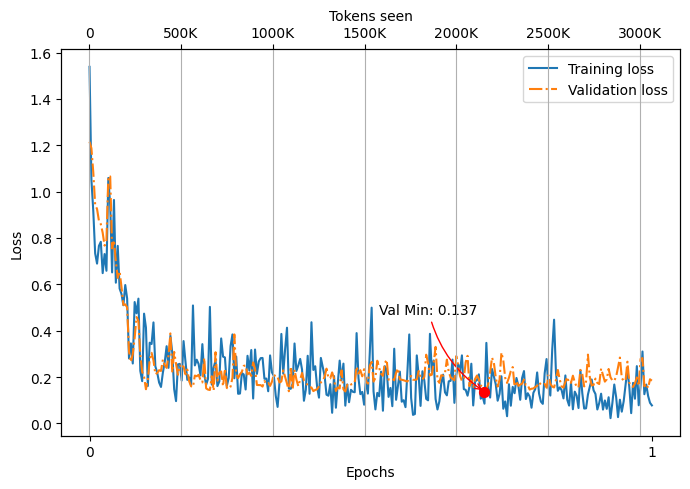

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/1024/2/medium

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-medium (355M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 1024)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 1024)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: collate_fn(x, 1024))
val_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: collate_fn(x, 1024))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.3898515939712524
Validation loss: 1.4462001584470272


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.704, Val loss 2.106 Train perplexity 2.022, Val perplexity 8.219
Ep 1 (Step 000005): Train loss 0.995, Val loss 1.450 Train perplexity 2.705, Val perplexity 4.264
Ep 1 (Step 000010): Train loss 0.844, Val loss 0.627 Train perplexity 2.326, Val perplexity 1.872
Ep 1 (Step 000015): Train loss 0.726, Val loss 0.845 Train perplexity 2.066, Val perplexity 2.329
Ep 1 (Step 000020): Train loss 0.663, Val loss 0.720 Train perplexity 1.940, Val perplexity 2.054
Ep 1 (Step 000025): Train loss 0.704, Val loss 0.644 Train perplexity 2.023, Val perplexity 1.905
Ep 1 (Step 000030): Train loss 1.042, Val loss 0.622 Train perplexity 2.834, Val perplexity 1.862
Ep 1 (Step 000035): Train loss 0.683, Val loss 0.765 Train perplexity 1.980, Val perplexity 2.150
Ep 1 (Step 000040): Train loss 0.742, Val loss 0.791 Train perplexity 2.100, Val perplexity 2.207
Ep 1 (Step 000045): Train loss 0.658, Val loss 0.889 Train perplexity 1.932, Val perplexity 2.433
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8753333333333333


Plotting losses...


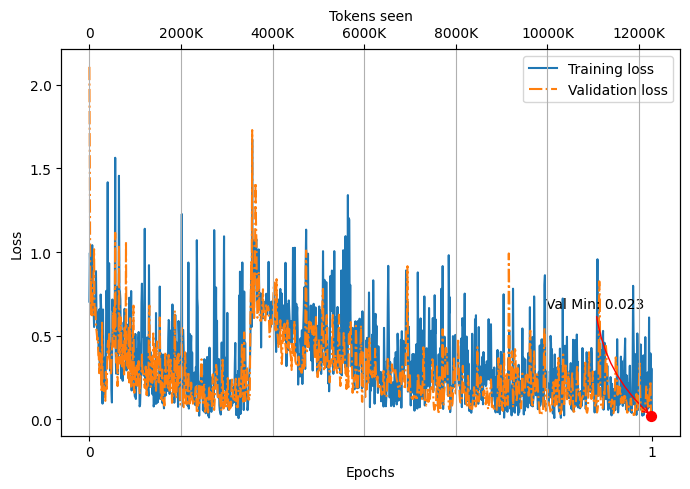

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/1024/8/medium

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-medium (355M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 1024)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 1024)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: collate_fn(x, 1024))
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: collate_fn(x, 1024))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.8713431119918824
Validation loss: 1.6736749082803726


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.600, Val loss 1.457 Train perplexity 1.822, Val perplexity 4.294
Ep 1 (Step 000005): Train loss 0.825, Val loss 0.733 Train perplexity 2.281, Val perplexity 2.081
Ep 1 (Step 000010): Train loss 0.679, Val loss 0.729 Train perplexity 1.973, Val perplexity 2.072
Ep 1 (Step 000015): Train loss 0.924, Val loss 0.918 Train perplexity 2.519, Val perplexity 2.504
Ep 1 (Step 000020): Train loss 0.779, Val loss 0.724 Train perplexity 2.179, Val perplexity 2.062
Ep 1 (Step 000025): Train loss 0.960, Val loss 0.799 Train perplexity 2.613, Val perplexity 2.224
Ep 1 (Step 000030): Train loss 0.601, Val loss 0.659 Train perplexity 1.824, Val perplexity 1.934
Ep 1 (Step 000035): Train loss 0.928, Val loss 0.779 Train perplexity 2.529, Val perplexity 2.180
Ep 1 (Step 000040): Train loss 0.647, Val loss 0.656 Train perplexity 1.909, Val perplexity 1.927
Ep 1 (Step 000045): Train loss 0.670, Val loss 0.637 Train perplexity 1.955, Val perplexity 1.890
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9423333333333334


Plotting losses...


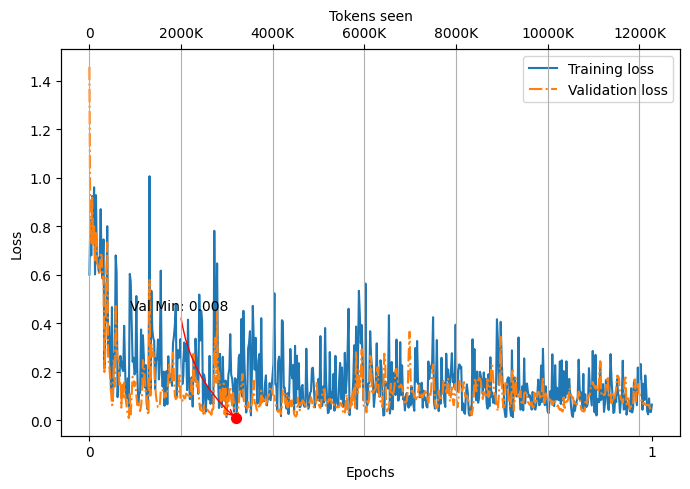

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Normal - 15k/256/8/Large

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-large (774M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.7522815823554992
Validation loss: 0.7726885676383972


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 1

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model_simple(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.491, Val loss 2.542 Train perplexity 12.068, Val perplexity 12.710
Ep 1 (Step 000005): Train loss 0.915, Val loss 0.836 Train perplexity 2.497, Val perplexity 2.306
Ep 1 (Step 000010): Train loss 0.759, Val loss 0.708 Train perplexity 2.136, Val perplexity 2.030
Ep 1 (Step 000015): Train loss 0.548, Val loss 0.537 Train perplexity 1.730, Val perplexity 1.711
Ep 1 (Step 000020): Train loss 0.348, Val loss 0.281 Train perplexity 1.416, Val perplexity 1.325
Ep 1 (Step 000025): Train loss 0.396, Val loss 0.563 Train perplexity 1.485, Val perplexity 1.756
Ep 1 (Step 000030): Train loss 0.382, Val loss 0.409 Train perplexity 1.465, Val perplexity 1.505
Ep 1 (Step 000035): Train loss 0.323, Val loss 0.315 Train perplexity 1.382, Val perplexity 1.370
Ep 1 (Step 000040): Train loss 0.243, Val loss 0.284 Train perplexity 1.276, Val perplexity 1.328
Ep 1 (Step 000045): Train loss 0.281, Val loss 0.376 Train perplexity 1.325, Val perplexity 1.456
Ep 1 (Step 000050)

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.934


Plotting losses...


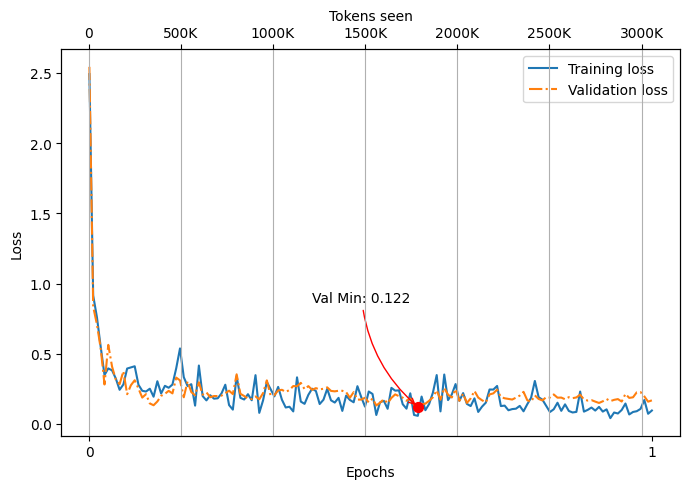

In [ ]:
plot_losses(experiment_configs, experiment_results)

# Training Model - Fine Tune Advanced - 15k/256/32/small

## Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
torch.manual_seed(123)

# GPT Configuration
CHOOSE_MODEL = "gpt2-medium (355M)"
model, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)
model.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAtte

In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.5062713623046875
Validation loss: 2.2917818784713746


In [ ]:
num_epochs = 15
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

num_epochs = 1
peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)

experiment_configs = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

experiment_results = train_model(experiment_configs)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.538, Val loss 1.215 Train perplexity 4.657, Val perplexity 3.371
Ep 1 (Step 000005): Train loss 1.052, Val loss 1.187 Train perplexity 2.863, Val perplexity 3.278
Ep 1 (Step 000010): Train loss 0.916, Val loss 1.083 Train perplexity 2.499, Val perplexity 2.955
Ep 1 (Step 000015): Train loss 0.733, Val loss 0.943 Train perplexity 2.082, Val perplexity 2.568
Ep 1 (Step 000020): Train loss 0.690, Val loss 0.925 Train perplexity 1.993, Val perplexity 2.522
Ep 1 (Step 000025): Train loss 0.766, Val loss 0.874 Train perplexity 2.151, Val perplexity 2.397
Ep 1 (Step 000030): Train loss 0.784, Val loss 0.860 Train perplexity 2.190, Val perplexity 2.363
Ep 1 (Step 000035): Train loss 0.648, Val loss 0.823 Train perplexity 1.913, Val perplexity 2.276
Ep 1 (Step 000040): Train loss 0.731, Val loss 0.767 Train perplexity 2.077, Val perplexity 2.154
Ep 1 (Step 000045): Train loss 0.659, Val loss 0.790 Train perplexity 1.932, Val perplexity 2.204
Ep 1 (Step 000050): 

In [ ]:
print(gpt_config["context_length"])

1024


In [ ]:
accuracy = calc_loader_accuracy(val_loader, model, device, num_batches=None)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9323333333333333


Plotting losses...


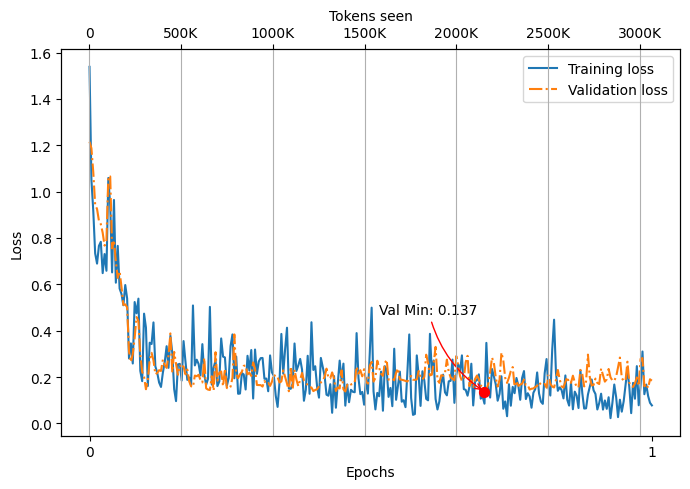

In [ ]:
plot_losses(experiment_configs, experiment_results)

# -----LORA-----

## Last N Transformers = 1

### Large Movie Review Dataset

In [18]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [19]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [20]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=1)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 1 transformer blocks (indices 23 to 23).
Total trainable LoRA parameters: 313,378
Training loss: 1.4233240842819215
Validation loss: 1.4862193822860719
Ep 1 (Iter 000000): Train loss 1.238, Val loss 1.449, Train perplexity 3.450, Val perplexity 4.258, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.728, Val loss 0.744, Train perplexity 2.071, Val perplexity 2.105, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.693, Val loss 0.680, Train perplexity 1.999, Val perplexity 1.975, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.690, Val loss 0.686, Train perplexity 1.994, Val perplexity 1.987, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.698, Val loss 0.664, Train perplexity 2.010, Val perplexity 1.943, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.673, Val loss 

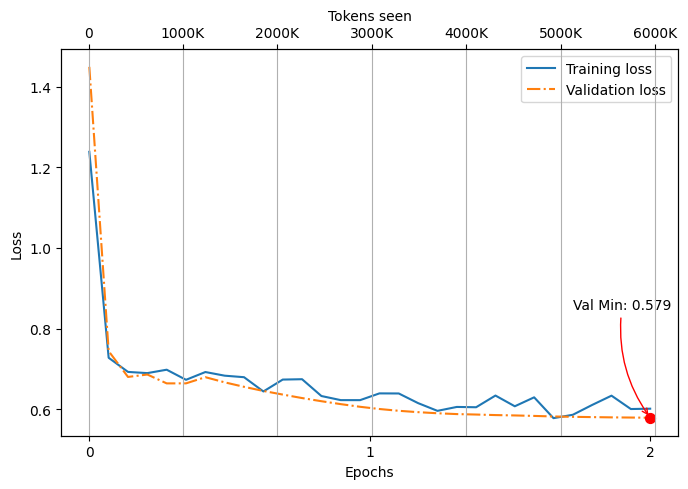

In [21]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 4

### Large Movie Review Dataset

In [14]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [15]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [16]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=4)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 4 transformer blocks (indices 20 to 23).
Total trainable LoRA parameters: 1,198,114
Training loss: 1.6356725692749023
Validation loss: 1.6485920190811156
Ep 1 (Iter 000000): Train loss 1.720, Val loss 1.562, Train perplexity 5.584, Val perplexity 4.768, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.725, Val loss 0.724, Train perplexity 2.064, Val perplexity 2.062, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.674, Val loss 0.711, Train perplexity 1.962, Val perplexity 2.035, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.658, Val loss 0.660, Train perplexity 1.931, Val perplexity 1.934, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.650, Val loss 0.606, Train perplexity 1.916, Val perplexity 1.834, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.394, Val los

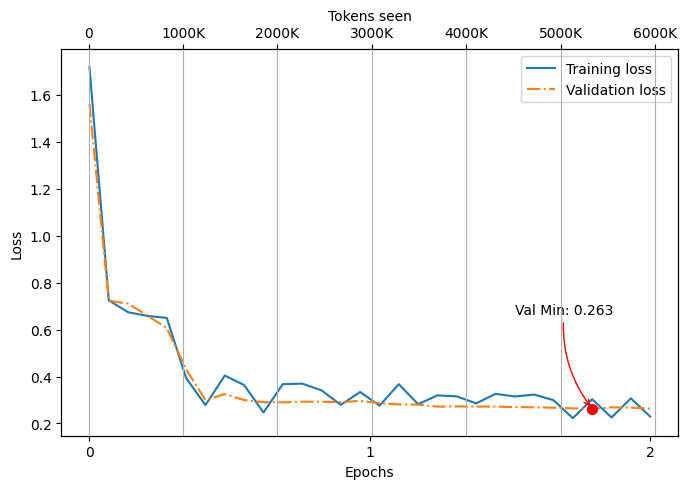

In [17]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 8

### Large Movie Review Dataset

In [21]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [22]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [23]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=8)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 8 transformer blocks (indices 16 to 23).
Total trainable LoRA parameters: 2,377,762
Training loss: 12.656708335876464
Validation loss: 12.59455909729004
Ep 1 (Iter 000000): Train loss 12.799, Val loss 12.370, Train perplexity 361918.156, Val perplexity 235615.375, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 2.875, Val loss 3.165, Train perplexity 17.734, Val perplexity 23.695, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 1.492, Val loss 1.215, Train perplexity 4.444, Val perplexity 3.369, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.734, Val loss 0.959, Train perplexity 2.084, Val perplexity 2.609, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.722, Val loss 0.796, Train perplexity 2.060, Val perplexity 2.218, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0

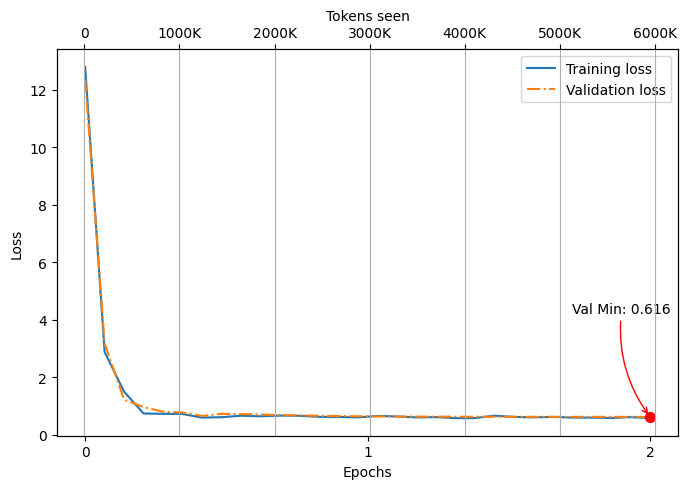

In [24]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 12

### Large Movie Review Dataset

In [14]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [15]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [16]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=12)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 12 transformer blocks (indices 12 to 23).
Total trainable LoRA parameters: 3,557,410
Training loss: 2.9273069858551026
Validation loss: 3.318632984161377
Ep 1 (Iter 000000): Train loss 1.900, Val loss 2.281, Train perplexity 6.683, Val perplexity 9.791, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.817, Val loss 0.719, Train perplexity 2.263, Val perplexity 2.053, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.665, Val loss 0.654, Train perplexity 1.945, Val perplexity 1.922, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.379, Val loss 0.379, Train perplexity 1.460, Val perplexity 1.461, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.278, Val loss 0.236, Train perplexity 1.320, Val perplexity 1.266, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.214, Val los

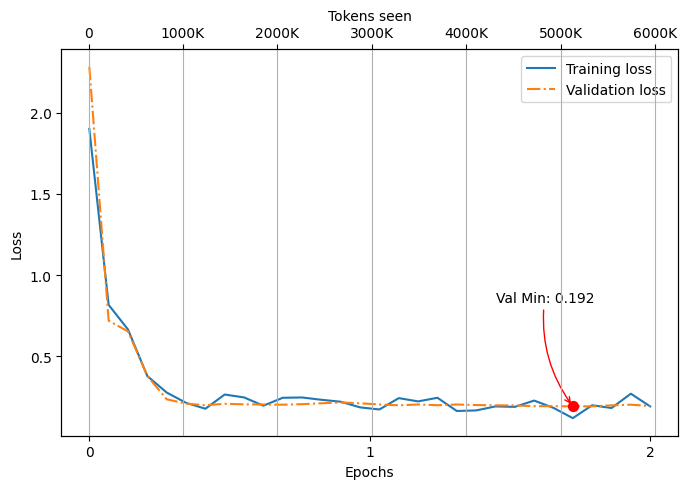

In [17]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 18

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=18)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 18 transformer blocks (indices 6 to 23).
Total trainable LoRA parameters: 5,326,882
Training loss: 3.946136713027954
Validation loss: 4.344219732284546
Ep 1 (Iter 000000): Train loss 4.825, Val loss 4.185, Train perplexity 124.623, Val perplexity 65.692, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.792, Val loss 0.701, Train perplexity 2.207, Val perplexity 2.017, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.675, Val loss 0.672, Train perplexity 1.965, Val perplexity 1.959, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.559, Val loss 0.563, Train perplexity 1.749, Val perplexity 1.756, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.317, Val loss 0.251, Train perplexity 1.373, Val perplexity 1.285, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.199, Val lo

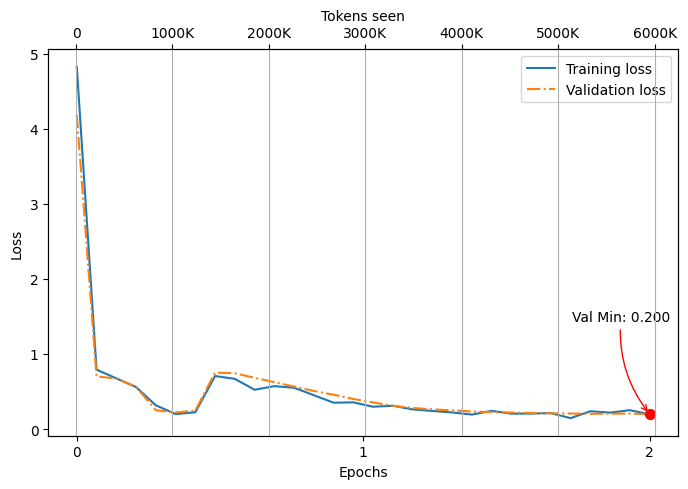

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 20

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=20)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 20 transformer blocks (indices 4 to 23).
Total trainable LoRA parameters: 5,916,706
Training loss: 2.031212639808655
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 0.997, Val loss 1.287, Train perplexity 2.710, Val perplexity 3.621, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.542, Val loss 0.597, Train perplexity 1.719, Val perplexity 1.816, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.317, Val loss 0.305, Train perplexity 1.374, Val perplexity 1.357, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.254, Val loss 0.245, Train perplexity 1.289, Val perplexity 1.277, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.283, Val loss 0.291, Train perplexity 1.327, Val perplexity 1.337, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.210, Val loss

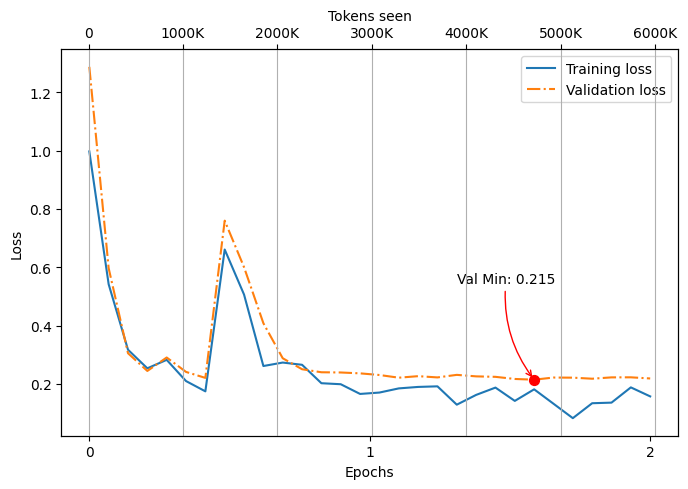

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 22

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=22)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 22 transformer blocks (indices 2 to 23).
Total trainable LoRA parameters: 6,506,530
Training loss: 1.7794445037841797
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 0.974, Val loss 1.294, Train perplexity 2.649, Val perplexity 3.647, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.521, Val loss 0.573, Train perplexity 1.683, Val perplexity 1.774, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.318, Val loss 0.304, Train perplexity 1.374, Val perplexity 1.355, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.250, Val loss 0.262, Train perplexity 1.284, Val perplexity 1.299, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.275, Val loss 0.270, Train perplexity 1.317, Val perplexity 1.310, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.195, Val los

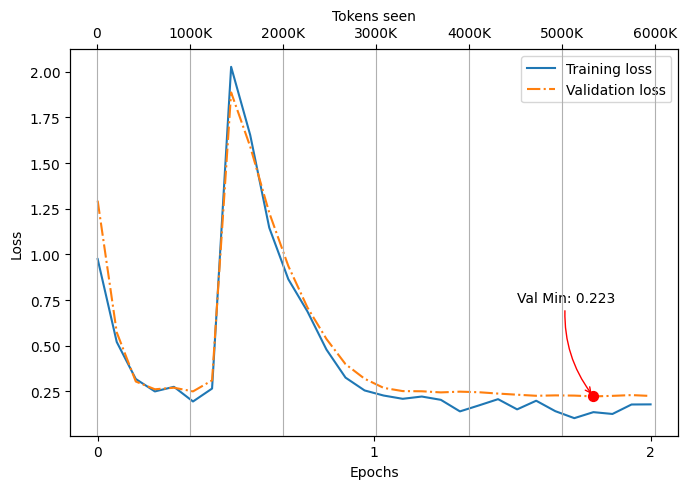

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Last N Transformers = 24

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=16, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 7,096,354
Training loss: 1.9721359014511108
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 0.960, Val loss 1.276, Train perplexity 2.612, Val perplexity 3.583, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.565, Val loss 0.595, Train perplexity 1.760, Val perplexity 1.812, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.315, Val loss 0.290, Train perplexity 1.370, Val perplexity 1.337, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.386, Val loss 0.356, Train perplexity 1.471, Val perplexity 1.427, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.342, Val loss 0.251, Train perplexity 1.408, Val perplexity 1.285, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.209, Val los

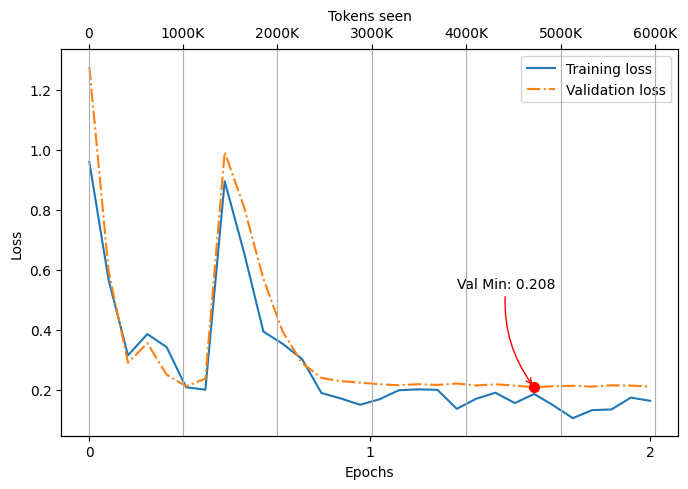

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Rank = 2



### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=2, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=2, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 888,838
Training loss: 1.4689489006996155
Validation loss: 1.501116943359375
Ep 1 (Iter 000000): Train loss 1.065, Val loss 1.279, Train perplexity 2.902, Val perplexity 3.592, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.742, Val loss 0.725, Train perplexity 2.100, Val perplexity 2.064, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.667, Val loss 0.661, Train perplexity 1.949, Val perplexity 1.937, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.424, Val loss 0.364, Train perplexity 1.528, Val perplexity 1.438, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.315, Val loss 0.273, Train perplexity 1.370, Val perplexity 1.313, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.239, Val loss 0.

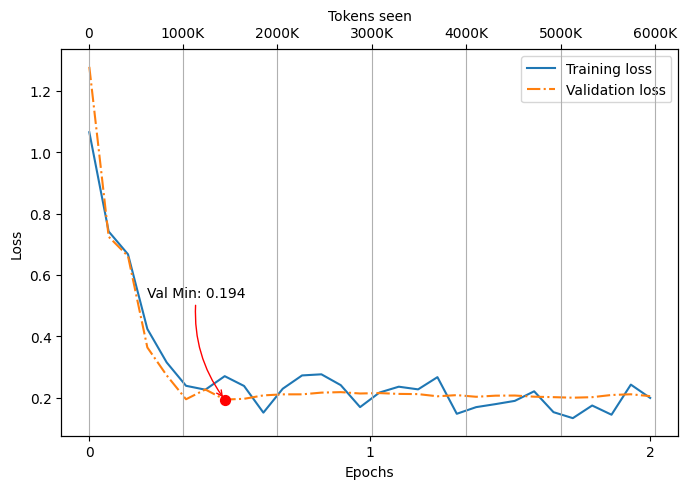

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Rank = 4

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=4, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=4, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 1,775,626
Training loss: 2.2250046730041504
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 1.113, Val loss 1.381, Train perplexity 3.045, Val perplexity 3.980, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.657, Val loss 0.710, Train perplexity 1.929, Val perplexity 2.035, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.432, Val loss 0.399, Train perplexity 1.541, Val perplexity 1.490, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.349, Val loss 0.263, Train perplexity 1.418, Val perplexity 1.301, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.302, Val loss 0.252, Train perplexity 1.352, Val perplexity 1.286, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.223, Val loss

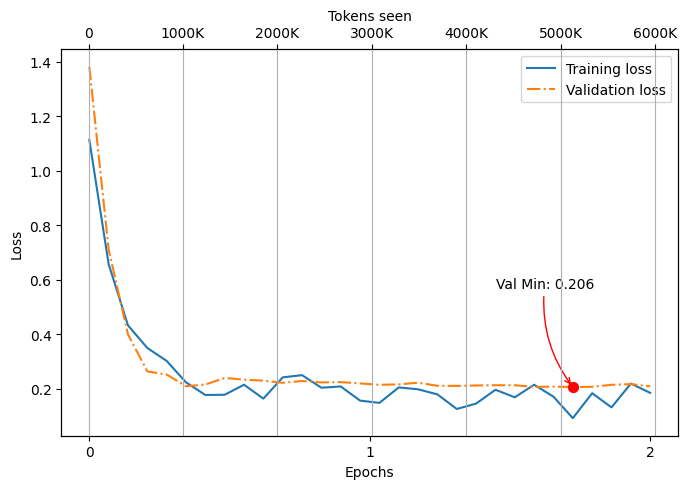

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Rank = 8

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=8, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=8, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 3,549,202
Training loss: 2.193104290962219
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 1.016, Val loss 1.285, Train perplexity 2.762, Val perplexity 3.614, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.571, Val loss 0.644, Train perplexity 1.769, Val perplexity 1.904, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.354, Val loss 0.365, Train perplexity 1.425, Val perplexity 1.440, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.268, Val loss 0.255, Train perplexity 1.307, Val perplexity 1.290, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.297, Val loss 0.274, Train perplexity 1.346, Val perplexity 1.315, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.190, Val loss 

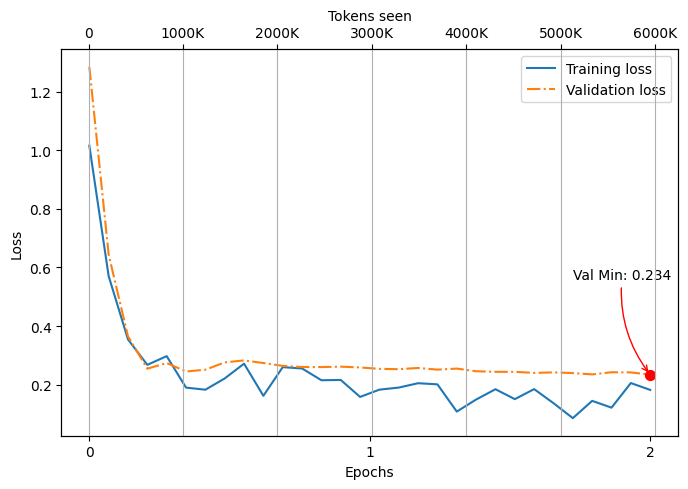

In [ ]:
experiment_result, experiment_configs = run_experiment()

## Rank = 32

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=32, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 2,050
Applying LoRA with rank=32, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 14,190,658
Training loss: 1.684305739402771
Validation loss: 1.9055118322372437
Ep 1 (Iter 000000): Train loss 0.855, Val loss 1.126, Train perplexity 2.352, Val perplexity 3.083, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.463, Val loss 0.472, Train perplexity 1.589, Val perplexity 1.603, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.313, Val loss 0.280, Train perplexity 1.367, Val perplexity 1.324, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.223, Val loss 0.243, Train perplexity 1.250, Val perplexity 1.275, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.247, Val loss 0.256, Train perplexity 1.280, Val perplexity 1.292, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.196, Val los

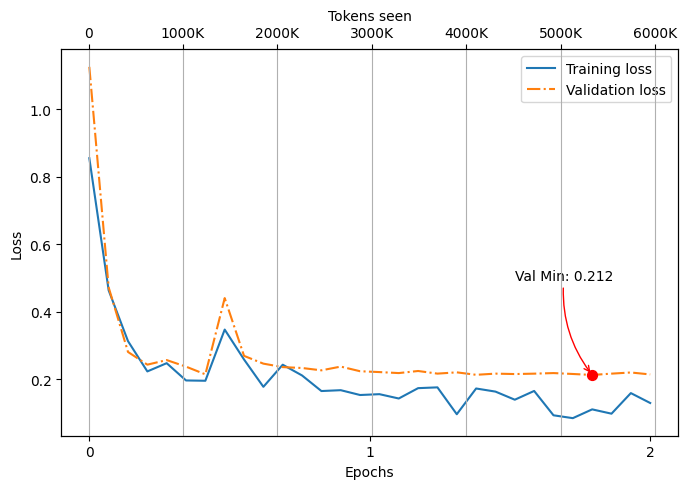

In [ ]:
experiment_result, experiment_configs = run_experiment()

## LoRA - Small

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-small (124M)"
    # CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Model Name: gpt2-small (124M)
	Total Parameters: 163,037,184
	Total Memory Requirement: 621.94 MB
Total trainable parameters before: 124,441,346
Total trainable parameters after: 1,538
Applying LoRA with rank=16, alpha=16 to the last 12 transformer blocks (indices 0 to 11).
Total trainable LoRA parameters: 2,668,066
Training loss: 2.767563557624817
Validation loss: 2.739423656463623
Ep 1 (Iter 000000): Train loss 2.602, Val loss 2.542, Train perplexity 13.490, Val perplexity 12.704, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.969, Val loss 0.957, Train perplexity 2.636, Val perplexity 2.603, LR 2.333e-05
Ep 1 (Iter 000050): Train loss 0.706, Val loss 0.749, Train perplexity 2.027, Val perplexity 2.115, LR 3.667e-05
Ep 1 (Iter 000075): Train loss 0.645, Val loss 0.727, Train perplexity 1.905, Val perplexity 2.069, LR 5.000e-05
Ep 1 (Iter 000100): Train loss 1.100, Val loss 1.175, Train perplexity 3.006, Val perplexity 3.238, LR 4.932e-05
Ep 1 (Iter 000125): Train loss 0.884, Val loss 

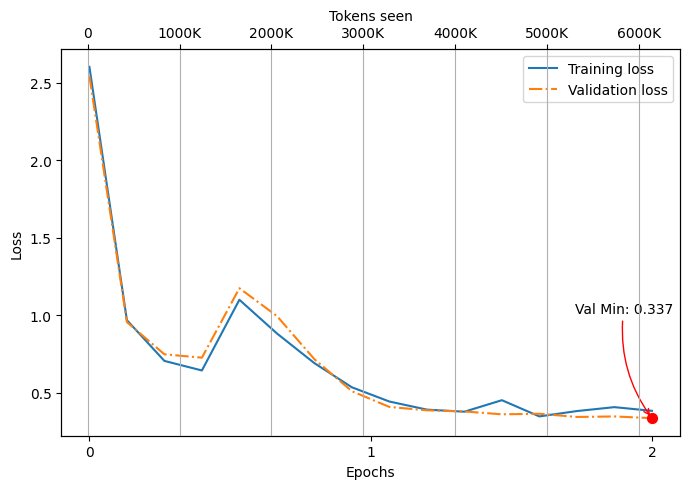

In [ ]:
experiment_result, experiment_configs = run_experiment()

## LoRA - Small - 32 batch

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-small (124M)"
    # CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Model Name: gpt2-small (124M)
	Total Parameters: 163,037,184
	Total Memory Requirement: 621.94 MB
Total trainable parameters before: 124,441,346
Total trainable parameters after: 1,538
Applying LoRA with rank=16, alpha=16 to the last 12 transformer blocks (indices 0 to 11).
Total trainable LoRA parameters: 2,668,066
Training loss: 2.410589838027954
Validation loss: 2.7525139331817625
Ep 1 (Iter 000000): Train loss 1.433, Val loss 1.581, Train perplexity 4.193, Val perplexity 4.860, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.691, Val loss 0.726, Train perplexity 1.996, Val perplexity 2.067, LR 1.667e-05
Ep 1 (Iter 000050): Train loss 0.667, Val loss 0.668, Train perplexity 1.949, Val perplexity 1.950, LR 2.333e-05
Ep 1 (Iter 000075): Train loss 0.405, Val loss 0.394, Train perplexity 1.499, Val perplexity 1.483, LR 3.000e-05
Ep 1 (Iter 000100): Train loss 0.379, Val loss 0.347, Train perplexity 1.461, Val perplexity 1.415, LR 3.667e-05
Ep 1 (Iter 000125): Train loss 0.249, Val loss 0

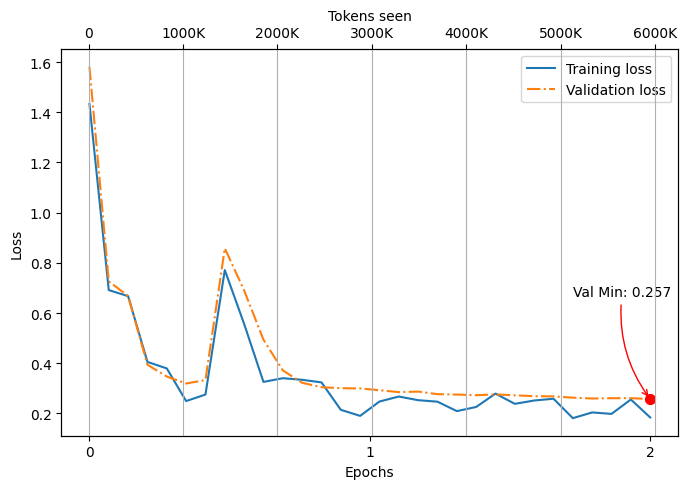

In [ ]:
experiment_result, experiment_configs = run_experiment()

## LoRA - Small - 32 - no warmup

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-small (124M)"
    # CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = 1

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

Model Name: gpt2-small (124M)
	Total Parameters: 163,037,184
	Total Memory Requirement: 621.94 MB
Total trainable parameters before: 124,441,346
Total trainable parameters after: 1,538
Applying LoRA with rank=16, alpha=16 to the last 12 transformer blocks (indices 0 to 11).
Total trainable LoRA parameters: 2,668,066
Training loss: 1.579921340942383
Validation loss: 1.3612270832061768
Ep 1 (Iter 000000): Train loss 1.379, Val loss 1.297, Train perplexity 3.970, Val perplexity 3.658, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.825, Val loss 0.724, Train perplexity 2.283, Val perplexity 2.063, LR 4.990e-05
Ep 1 (Iter 000050): Train loss 0.737, Val loss 0.734, Train perplexity 2.090, Val perplexity 2.083, LR 4.958e-05
Ep 1 (Iter 000075): Train loss 0.701, Val loss 0.701, Train perplexity 2.017, Val perplexity 2.015, LR 4.904e-05
Ep 1 (Iter 000100): Train loss 0.697, Val loss 0.661, Train perplexity 2.007, Val perplexity 1.937, LR 4.830e-05
Ep 1 (Iter 000125): Train loss 0.668, Val loss 0

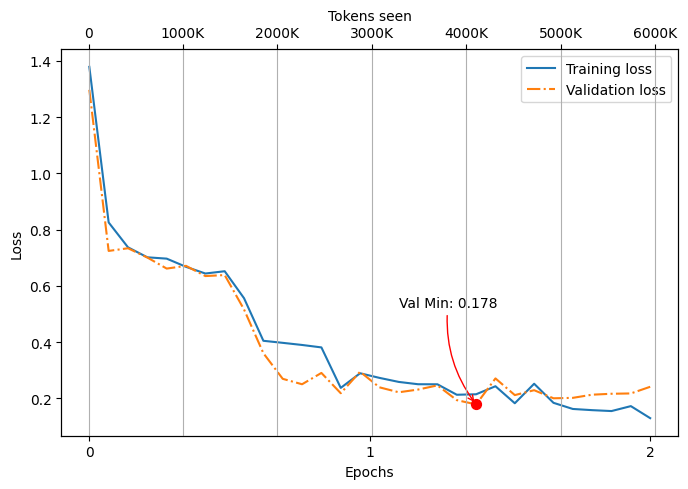

In [ ]:
experiment_result, experiment_configs = run_experiment()

## LoRA - Large - 32 - no warmup

### Large Movie Review Dataset

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

large_movie_review_dataset = GOOGLE_DRIVE_PATH + '/sentiment_fine_tune/IMDB Dataset.csv'

df = pd.read_csv(large_movie_review_dataset)


df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

df = df.sample(n=15000, random_state=5).reset_index(drop=True)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=5
)


print(f"Loaded {len(df)} samples.")
print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Example training sample: {train_texts.iloc[0]}")
print(f"Example training label: {train_labels.iloc[0]}")  # 0 = negative, 1 = positive

Loaded 15000 samples.
Training samples: 12000, Testing samples: 3000
Example training sample: That is the promise of the trailer I saw and by which I rented Hitch. Exactly, a serious film viewer shall not expect much further from this title but, surprisingly enough, Smith, Mendes, James and Valletta managed to reach a theatrical performance which could be metaphorically summarised on their rap dance-floor routine by the end of the film: their characters formed an effective combo which may prompt more than a good laugh with this Sunday afternoon DVD, providing your date is not an exquisite, french-swedish-directors-of-the-60's movie fan.<br /><br />P.S.: The techniques to score are all TRUE, especially the "cocktail girl" routine!
Example training label: 1


In [ ]:
from torch.utils.data import DataLoader, Dataset


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, context_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.context_length = context_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoded = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        encoded_tensor = torch.tensor(encoded[:self.context_length], dtype=torch.long)
        return encoded_tensor, torch.tensor(label, dtype=torch.float)

# Truncate + pad by token size
def collate_fn(batch, context_length):
    texts, labels = zip(*batch)
    padded_texts = torch.zeros(len(texts), context_length, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.stack(labels)

tokenizer = tiktoken.get_encoding("gpt2")


train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, 256)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_fn(x, 256))
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: collate_fn(x, 256))

In [ ]:
def run_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Initialize a Pre-trained GPT model
    # CHOOSE_MODEL = "gpt2-small (124M)"
    # CHOOSE_MODEL = "gpt2-medium (355M)"
    CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m, gpt_config = get_pretrained_gpt_model(CHOOSE_MODEL)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=gpt_config["emb_dim"], out_features=2)
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)

    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = 1

    experiment_configs = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
    )
    # experiment_result = train_model_simple(experiment_configs)
    experiment_result = train_model(experiment_configs)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=None)
    print(f"Accuracy: {accuracy}")

    # 3c) Plot learning curves
    plot_losses(experiment_configs, experiment_result)

    return experiment_result, experiment_configs

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Model Name: gpt2-large (774M)
	Total Parameters: 838,359,040
	Total Memory Requirement: 3198.09 MB
Total trainable parameters before: 774,032,642
Total trainable parameters after: 2,562
Applying LoRA with rank=16, alpha=16 to the last 24 transformer blocks (indices 12 to 35).
Total trainable LoRA parameters: 8,870,434
Training loss: 0.6905112385749816
Validation loss: 0.7340192556381225
Ep 1 (Iter 000000): Train loss 0.679, Val loss 0.692, Train perplexity 1.972, Val perplexity 1.998, LR 1.000e-05
Ep 1 (Iter 000025): Train loss 0.340, Val loss 0.328, Train perplexity 1.406, Val perplexity 1.389, LR 4.990e-05
Ep 1 (Iter 000050): Train loss 0.235, Val loss 0.201, Train perplexity 1.265, Val perplexity 1.222, LR 4.958e-05
Ep 1 (Iter 000075): Train loss 0.200, Val loss 0.174, Train perplexity 1.221, Val perplexity 1.190, LR 4.904e-05
Ep 1 (Iter 000100): Train loss 0.277, Val loss 0.229, Train perplexity 1.319, Val perplexity 1.257, LR 4.830e-05
Ep 1 (Iter 000125): Train loss 0.150, Val los

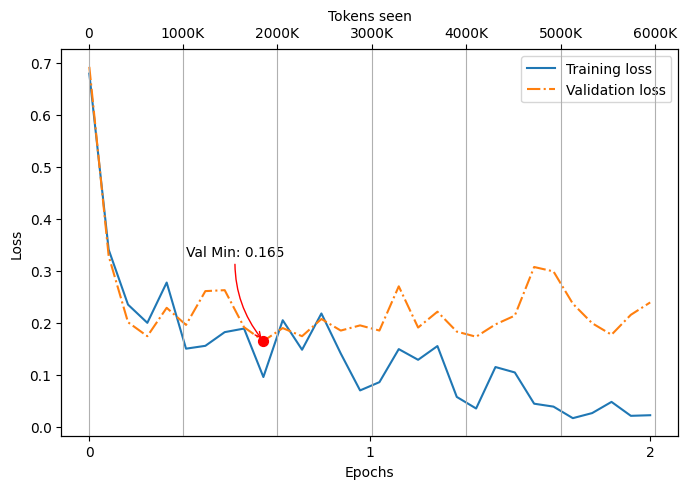

In [ ]:
experiment_result, experiment_configs = run_experiment()